# **Flowers Classification using Deep Learning**

### **1. Problem Statement**

Develop an automated system for accurately classifying images of flowers into five distinct categories: roses, daisies, dandelions, sunflowers, and tulips.

### **2. Domain Analysis**
The project aims to classify images of flowers into one of five categories: roses, daisies, dandelions, sunflowers, and tulips, using a deep learning model.

### **3. Data Collection and Preprocessing**
Download the dataset: <a href=" https://d3ilbtxij3aepc.cloudfront.net/projects/CNN-PROJECT-1-6/flower-classes-5.zip"> Flowers Classification Dataset</a>


In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import the dataset and necessary libraries

In [2]:
# Import and Unzip the file
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/flowers.zip'

# Directory where you want to extract the contents
flower_images = '/content/extracted_folder'

# Create the directory if it doesn't exist
os.makedirs(flower_images, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(flower_images)

In [3]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from glob import glob
import PIL
import matplotlib.pyplot as plt

In [4]:
#Count how many images are present in each class
import os

count = 0
base_path = '/content/extracted_folder/flowers'
dirs = os.listdir(base_path)

for dir in dirs:
    dir_path = os.path.join(base_path, dir)
    if os.path.isdir(dir_path):  # Check if it's a directory
        files = os.listdir(dir_path)
        print(f'{dir} folder has {len(files)} images')
        count += len(files)

print(f"Total images of flowers folder has {count} images")


dandelion folder has 898 images
daisy folder has 633 images
sunflowers folder has 699 images
tulips folder has 799 images
roses folder has 641 images
Total images of flowers folder has 3670 images


In [5]:
! pip install split-folders

In [6]:
import splitfolders
splitfolders.ratio("/content/extracted_folder/flowers/",output='subset',ratio=(0.8,0.1,0.1),seed=137)


Copying files: 3670 files [00:01, 2551.69 files/s]


In [7]:
# Resize all the images and create the train, val, test batches of images
image_size = [224, 224]

train_path = '/content/subset/train'
valid_path = '/content/subset/val'
test_path = '/content/subset/test'


In [8]:
# Get the number of output classes
folders = glob('/content/subset/train/*')

In [9]:
folders

['/content/subset/train/dandelion',
 '/content/subset/train/daisy',
 '/content/subset/train/sunflowers',
 '/content/subset/train/tulips',
 '/content/subset/train/roses']

In [10]:
!pip install opencv-python

### **4. Visualize the images belongs to each class**

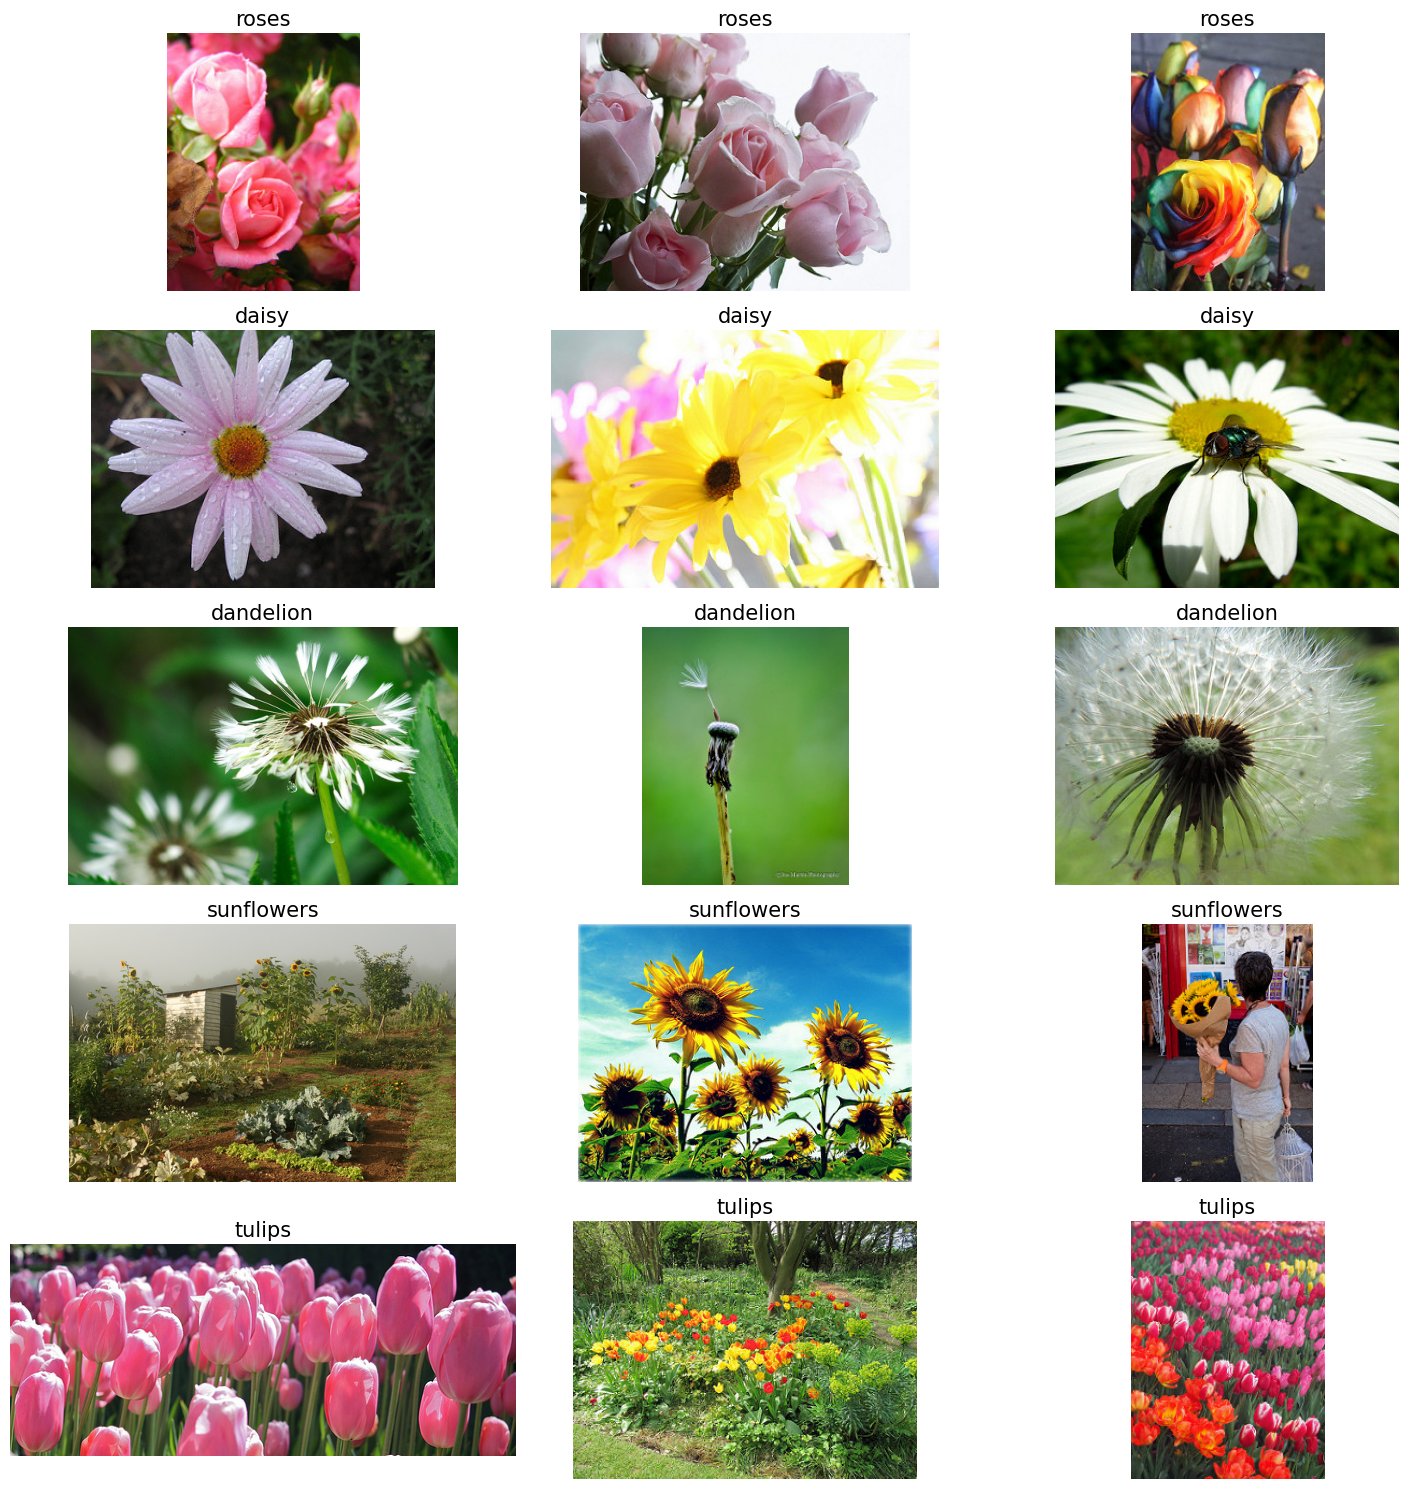

In [11]:
import os
import cv2
import matplotlib.pyplot as plt

def load_images_from_folder(folders, num_images=3):
    images = []
    for filename in os.listdir(folders)[:num_images]:
        img_path = os.path.join(folders, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    return images

def plot_images(images, labels, num_images_per_class=3):
    num_classes = len(images)
    fig, axs = plt.subplots(num_classes, num_images_per_class, figsize=(15, 3 * num_classes))

    for class_idx, class_images in enumerate(images):
        for img_idx in range(num_images_per_class):
            x = axs[class_idx, img_idx]
            x.imshow(class_images[img_idx])
            x.axis('off')
            x.set_title(labels[class_idx], fontsize=15)

    plt.tight_layout()
    plt.show()

# Define the path to your dataset
dataset_path = '/content/extracted_folder/flowers'

# Define the flower classes (subdirectory names)
flower_classes = ['roses', 'daisy','dandelion', 'sunflowers', 'tulips']

# Load images
images_per_class = []
for flower_class in flower_classes:
    folder_path = os.path.join(dataset_path, flower_class)
    images = load_images_from_folder(folder_path)
    images_per_class.append(images)

# Plot images
plot_images(images_per_class, flower_classes)


In [12]:
# Getting the no of classes present in folder
folders = glob("/content/subset/train/*")
len(folders)

5

### **4. Image data augmentation**

In [13]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

### **5. Data Preperation**

In [14]:
training_set = train_datagen.flow_from_directory(
    '/content/subset/train/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_set = val_datagen.flow_from_directory(
    '/content/subset/val/',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 2934 images belonging to 5 classes.
Found 364 images belonging to 5 classes.


### **3. Model Selection and preperation**


*   Choose the model
*   Modify and bulid the architecture

**ResNet101**, a convolutional neural network (CNN), was chosen for its exceptional performance in image classification tasks, balancing accuracy and computational efficiency effectively.

- ResNet101 is a powerful CNN architecture, excels in image classification due to its deep structure with residual connections. These connections alleviate training challenges by facilitating the flow of gradients, enabling effective learning of intricate image features.

- Pre-trained on ImageNet, ResNet101 initializes with learned weights, enhancing performance and enabling rapid adaptation to new tasks.
- Its efficiency in training, coupled with high accuracy, makes it ideal for diverse applications, from recognizing different flower species to handling complex visual tasks.



In [15]:
#Import the the EfficientNetB0 model and build the architecture
resnet_model = ResNet101(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

#Adding layers
x = resnet_model.output
x = GlobalAveragePooling2D()(x) # reduces the number of parameters in the model.
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=resnet_model.input, outputs=predictions)

171446536/171446536 [==============================] - 1s 0us/step


In [16]:
# Visualise the number of trainable parameters of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [18]:
# Don't train the existing weights
for layer in resnet_model.layers:
    layer.trainable = False

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Flow chart for the EfficientNetB0 model

In [20]:
!pip install pydot graphviz

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.871718 to fit



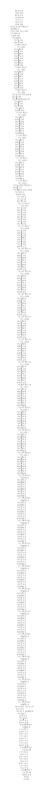

In [21]:
# Import plot model library
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Show the saved model
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()


### **6. Model training**

In [22]:
# Train the model
history = model.fit(training_set,
                    epochs=50,
                    validation_data=val_set,
                    steps_per_epoch=len(training_set),
                    validation_steps=len(val_set))

Epoch 1/50
92/92 [==============================] - 73s 581ms/step - loss: 1.5524 - accuracy: 0.3272 - val_loss: 1.5442 - val_accuracy: 0.3352
Epoch 2/50
92/92 [==============================] - 52s 567ms/step - loss: 1.4698 - accuracy: 0.3613 - val_loss: 1.3844 - val_accuracy: 0.4203
Epoch 3/50
92/92 [==============================] - 49s 534ms/step - loss: 1.4312 - accuracy: 0.4001 - val_loss: 1.5378 - val_accuracy: 0.3242
Epoch 4/50
92/92 [==============================] - 50s 543ms/step - loss: 1.4265 - accuracy: 0.3967 - val_loss: 1.4752 - val_accuracy: 0.3956
Epoch 5/50
92/92 [==============================] - 49s 535ms/step - loss: 1.3904 - accuracy: 0.4233 - val_loss: 1.3641 - val_accuracy: 0.4258
Epoch 6/50
92/92 [==============================] - 50s 538ms/step - loss: 1.3897 - accuracy: 0.4315 - val_loss: 1.3202 - val_accuracy: 0.4533
Epoch 7/50
92/92 [==============================] - 50s 541ms/step - loss: 1.3592 - accuracy: 0.4404 - val_loss: 1.3719 - val_accuracy: 0.4588

### Fine tuning

In [23]:
# Unfreeze some layers in the base model for fine-tuning
for layer in resnet_model.layers[-20:]:
    layer.trainable = True

In [24]:
# fine tuned Model complitation
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
#train the model again
history_fine = model.fit(training_set,
                         epochs=10,
                         validation_data=val_set)

Epoch 1/10
92/92 [==============================] - 62s 552ms/step - loss: 1.5014 - accuracy: 0.4455 - val_loss: 1.5412 - val_accuracy: 0.4038
Epoch 2/10
92/92 [==============================] - 50s 538ms/step - loss: 1.2762 - accuracy: 0.4908 - val_loss: 1.4238 - val_accuracy: 0.4011
Epoch 3/10
92/92 [==============================] - 49s 537ms/step - loss: 1.2322 - accuracy: 0.5099 - val_loss: 1.3934 - val_accuracy: 0.4670
Epoch 4/10
92/92 [==============================] - 49s 529ms/step - loss: 1.2021 - accuracy: 0.5174 - val_loss: 1.2675 - val_accuracy: 0.4808
Epoch 5/10
92/92 [==============================] - 49s 535ms/step - loss: 1.1803 - accuracy: 0.5331 - val_loss: 1.2442 - val_accuracy: 0.5385
Epoch 6/10
92/92 [==============================] - 50s 539ms/step - loss: 1.1457 - accuracy: 0.5443 - val_loss: 1.5071 - val_accuracy: 0.4038
Epoch 7/10
92/92 [==============================] - 48s 523ms/step - loss: 1.1413 - accuracy: 0.5389 - val_loss: 1.1310 - val_accuracy: 0.5742

Note: In fine-tuning a lower learning rate and fewer epochs is taken as the base EfficientNetB0 model has lot of information. So, fine-tuning too many layers for too long can lead to overfitting and increased training time without significant performance gains.

### **7. Combining both the history for visualization**

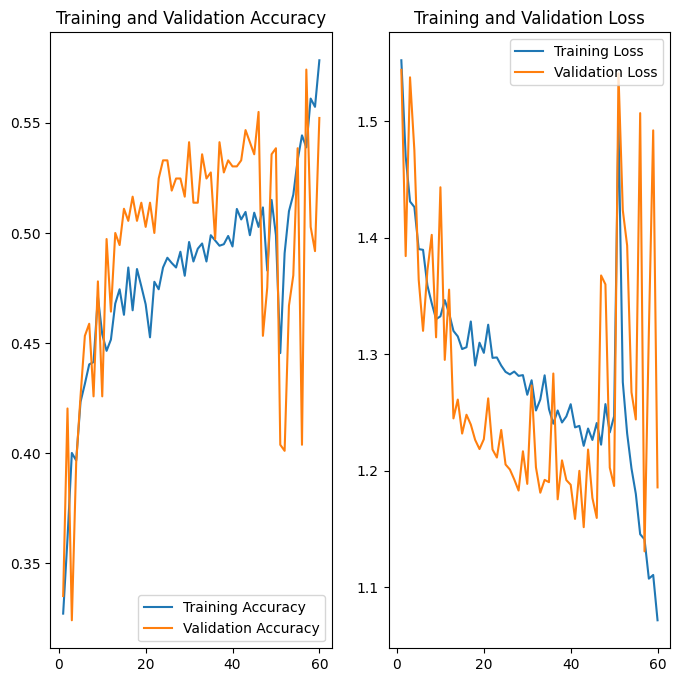

In [26]:
# Combine both the train model and fine tuned model and plot the training history
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **8. Model Evaluation**

In [27]:
# Model evaluation on training
loss, accuracy = model.evaluate(training_set)
print(f'Training Loss: {loss}')
print(f'Training Accuracy: {accuracy}')

# Model evaluation on validation
loss, accuracy = model.evaluate(val_set)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

92/92 [==============================] - 46s 497ms/step - loss: 1.1711 - accuracy: 0.5314
Training Loss: 1.1711245775222778
Training Accuracy: 0.5313565135002136
12/12 [==============================] - 2s 173ms/step - loss: 1.1859 - accuracy: 0.5522
Validation Loss: 1.1858863830566406
Validation Accuracy: 0.5521978139877319


### **9. Model Saving**

In [28]:
# Model saving
model.save('flower_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **10. Prediction on test data**

In [29]:
# Image data augmentation for test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_set = test_datagen.flow_from_directory(
    '/content/subset/test/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 372 images belonging to 5 classes.


In [30]:
predictions = model.predict(test_set)
predictions

12/12 [==============================] - 6s 327ms/step


array([[1.4426550e-01, 3.4050647e-02, 2.1839367e-01, 1.9869165e-01,
        4.0459847e-01],
       [3.3384991e-01, 2.2433810e-02, 1.6174626e-01, 5.5032901e-02,
        4.2693707e-01],
       [5.4284871e-01, 3.1627139e-01, 3.5424896e-02, 7.4161906e-03,
        9.8038800e-02],
       ...,
       [3.3935835e-04, 3.9963407e-04, 4.3114717e-03, 1.2003952e-02,
        9.8294556e-01],
       [5.6453969e-02, 5.8033269e-02, 1.2659183e-01, 3.2769486e-02,
        7.2615147e-01],
       [1.9402925e-02, 2.9585809e-02, 7.7262484e-02, 4.1274775e-02,
        8.3247399e-01]], dtype=float32)

In [31]:
predicted_class = predictions.argmax(axis=1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

### **11. Visualize the Predicted class**

In [40]:
# Create a diverse set of samples in order to get the images from each class and predict
def get_diverse_samples(generator, num_samples=9):
    images, true_labels = [], []
    classes_count = {label: 0 for label in range(5)}
    while len(images) < num_samples:
        batch_images, batch_labels = next(generator)
        for img, lbl in zip(batch_images, batch_labels):
            class_idx = np.argmax(lbl)
            if classes_count[class_idx] < num_samples / 5:
                images.append(img)
                true_labels.append(class_idx)
                classes_count[class_idx] += 1
            if len(images) >= num_samples:
                break
    return np.array(images), np.array(true_labels)
# Get diverse samples
test_images, true_labels = get_diverse_samples(test_set, num_samples=9)
predicted_labels = predicted_class[:9]

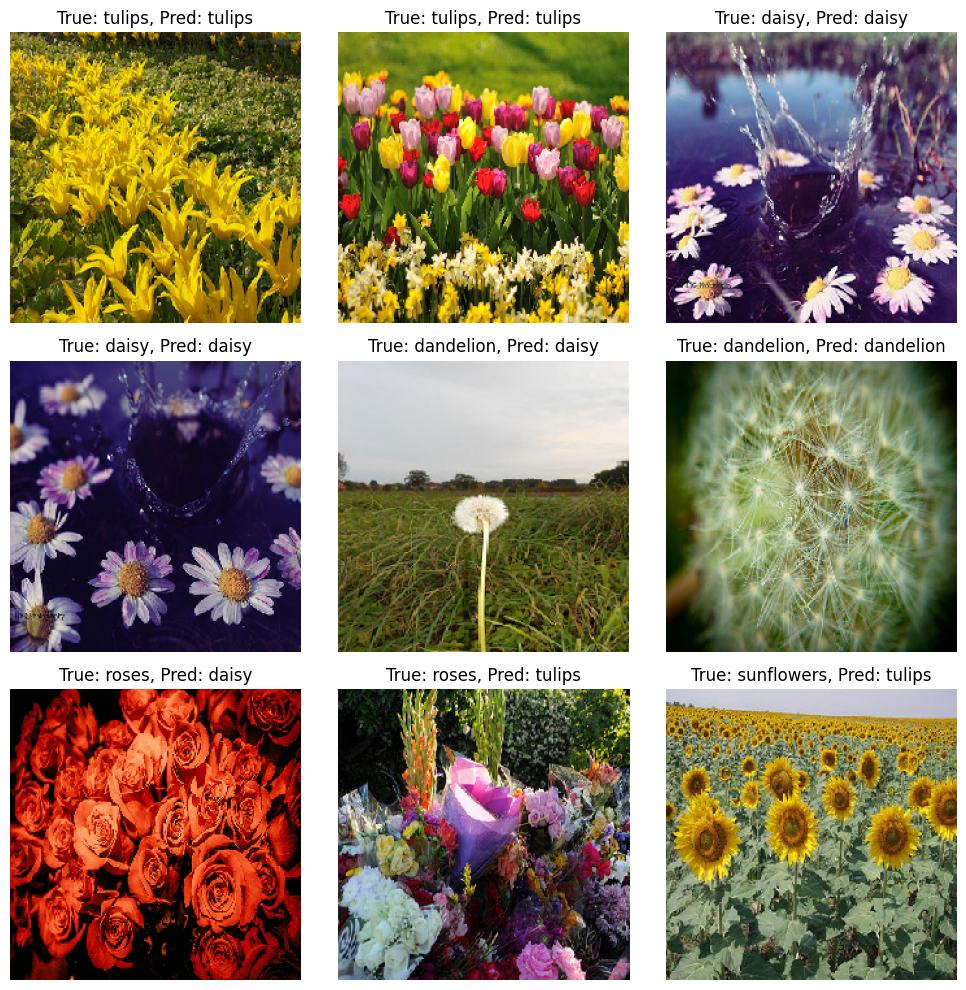

In [41]:
#plot the images
def plot_images(img_array, true_labels, predicted_labels, class_labels):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for img, true_lbl, pred_lbl, x in zip(img_array, true_labels, predicted_labels, axes):
        x.imshow(img)
        true_class = class_labels[true_lbl]
        predicted_class = class_labels[pred_lbl]
        x.set_title(f"True: {true_class}, Pred: {predicted_class}")
        x.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the images with their true and predicted labels
plot_images(test_images, true_labels, predicted_labels, class_labels)

### **12. Conclusion**

In this project, we successfully built a flower classification model using the ResNet101 architecture. By leveraging transfer learning, we were able to use a pre-trained model and fine-tune it for our specific task of classifying five types of flowers: roses, daisies, dandelions, sunflowers, and tulips.

We prepared the data with various augmentation techniques to enhance the model's robustness and prevent overfitting. The model was initially trained with the base layers frozen, then fine-tuned by unfreezing some layers to further improve accuracy.

We had previously trained the flower classfication dataset on various transfer learning models with val accuracy of EfficinetnetB0(0.23),EfficientNetB4(0.34), ResNet50(0.43), with ResNet50 we got the val accuracy of 0.55; which is far better than the previous models prediction. You can improve the accuracy by increasing the total number of epochs. Due to computational costs, we are not able to perform well.

After training, we evaluated the model's performance on a validation set and visualized its predictions on a test set. Despite the challenges, our approach demonstrated the potential of deep learning models in accurately classifying different flower species, achieving a solid accuracy that can be further improved with more data and fine-tuning.

Overall, this project showcases the practical application of advanced neural network architectures in image classification tasks, highlighting the power and flexibility of transfer learning in achieving high accuracy with relatively small datasets.